## Predicting Credit Default and assessing the role of 'Gender' in the process

In [ ]:
"""
# Open questions to business experts?

1. Is there some value in getting the Customer IDs (CURRENT ID and OLD SYSTEM ID) ?
2. What education levels do 4=others, 5,6=unknown in EDUCATION denote?
3. What marital status does 3=others in MARRIAGE denote?
"""

In [37]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats # To use Z-score for outlier detection
import seaborn as sns
from scipy.stats import chisquare #For chi-squared correlation detection

In [38]:
#Importing data
path = r'C:\Users\Karandeep\Downloads\New folder\Ethics in AI codes'
df = pd.read_excel(path + '\credit data.xlsx')

In [41]:
#Checking the balance of the dataset - default.payment.next.month
df['default.payment.next.month'].value_counts()

0    11494
1     3506
Name: default.payment.next.month, dtype: int64

## We do see that this is an imbalanced dataset - True Positives(Customers that default) are only ~25% 

In [86]:
#Checking how many males vs females are there in the dataset
df['SEX'].value_counts()

1    11888
2     3112
Name: SEX, dtype: int64

## We do see that the data is also imbalanced in a Gender bias sense that the Male: Female ratio is 11888:3112

In [42]:
#Checking structure of dataset columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 26 columns):
CURRENT ID                    15000 non-null int64
OLD SYSTEM ID                 15000 non-null int64
LIMIT_BAL                     15000 non-null float64
SEX                           15000 non-null int64
EDUCATION                     15000 non-null int64
MARRIAGE                      15000 non-null int64
AGE                           15000 non-null int64
PAY_0                         15000 non-null int64
PAY_2                         15000 non-null int64
PAY_3                         15000 non-null int64
PAY_4                         15000 non-null int64
PAY_5                         15000 non-null int64
PAY_6                         15000 non-null int64
BILL_AMT1                     15000 non-null float64
BILL_AMT2                     15000 non-null float64
BILL_AMT3                     15000 non-null float64
BILL_AMT4                     15000 non-null float64
BILL_AMT5     

In [43]:
# Drop the ID columns as they are not required
df.drop(labels = ['CURRENT ID','OLD SYSTEM ID'], axis = 1, inplace = True)

# Convert the required columns to Categorical as we know they should be Categorical
df['SEX'] = df['SEX'].astype('category', ordered = False)
# Could have used the construct ser.astype('category', ordered=True, categories=[2, 1]) because education is 'ordered' categorical
# But, since we did not have clarity on values = 4,5,6 we used unordered categorical
df['EDUCATION'] = df['EDUCATION'].astype('category', ordered = False)
#Similarly, for MARRIAGE, the value = 3 was not clear, so used unordered cateorical
df['MARRIAGE'] = df['MARRIAGE'].astype('category', ordered = False)
df['default.payment.next.month'] = df['default.payment.next.month'].astype('category', ordered = False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
LIMIT_BAL                     15000 non-null float64
SEX                           15000 non-null category
EDUCATION                     15000 non-null category
MARRIAGE                      15000 non-null category
AGE                           15000 non-null int64
PAY_0                         15000 non-null int64
PAY_2                         15000 non-null int64
PAY_3                         15000 non-null int64
PAY_4                         15000 non-null int64
PAY_5                         15000 non-null int64
PAY_6                         15000 non-null int64
BILL_AMT1                     15000 non-null float64
BILL_AMT2                     15000 non-null float64
BILL_AMT3                     15000 non-null float64
BILL_AMT4                     15000 non-null float64
BILL_AMT5                     15000 non-null float64
BILL_AMT6                     15000 non-null float64
P

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  # This is added back by InteractiveShellApp.init_path()


In [44]:
#Checking null values in the data
df.isnull().sum().sum()

0

No null values found

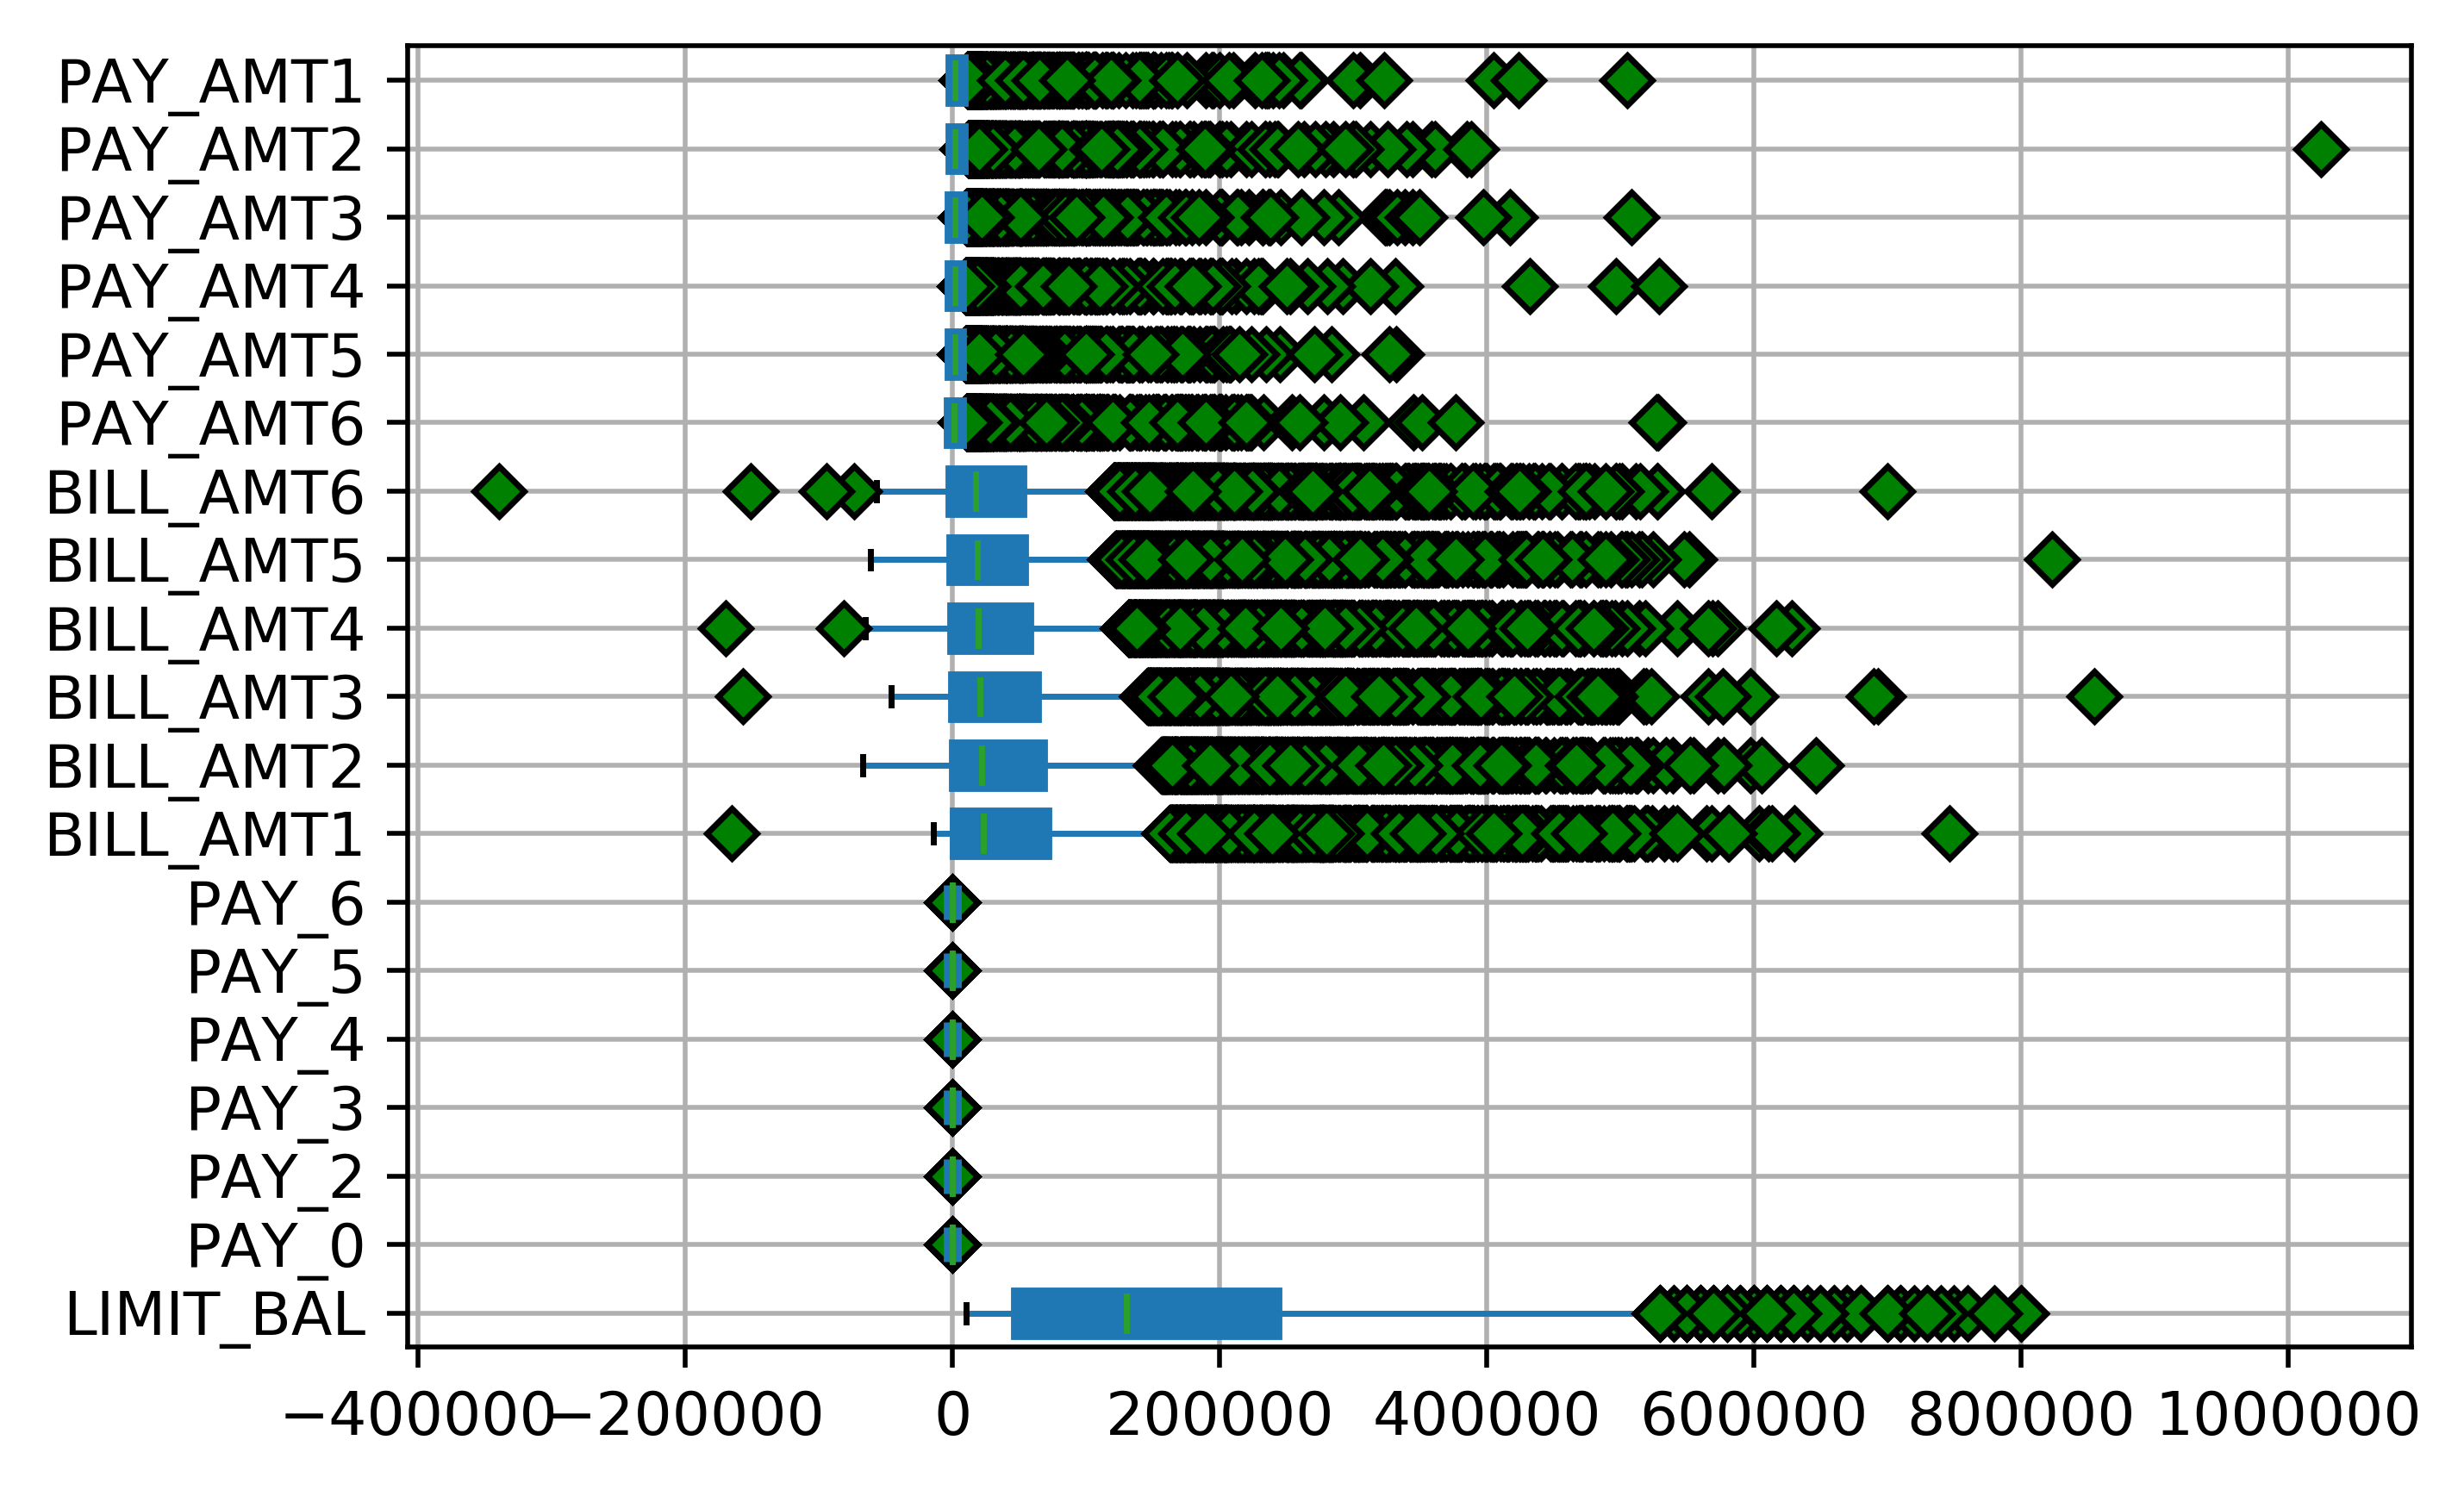

In [45]:
plt.figure(dpi = 500)
df.boxplot(column = ['LIMIT_BAL','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                     'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                     'PAY_AMT6','PAY_AMT5','PAY_AMT4','PAY_AMT3','PAY_AMT2','PAY_AMT1'], 
           vert = False, patch_artist = True, flierprops=dict(markerfacecolor='g', marker='D'), boxprops = dict(linewidth=3))

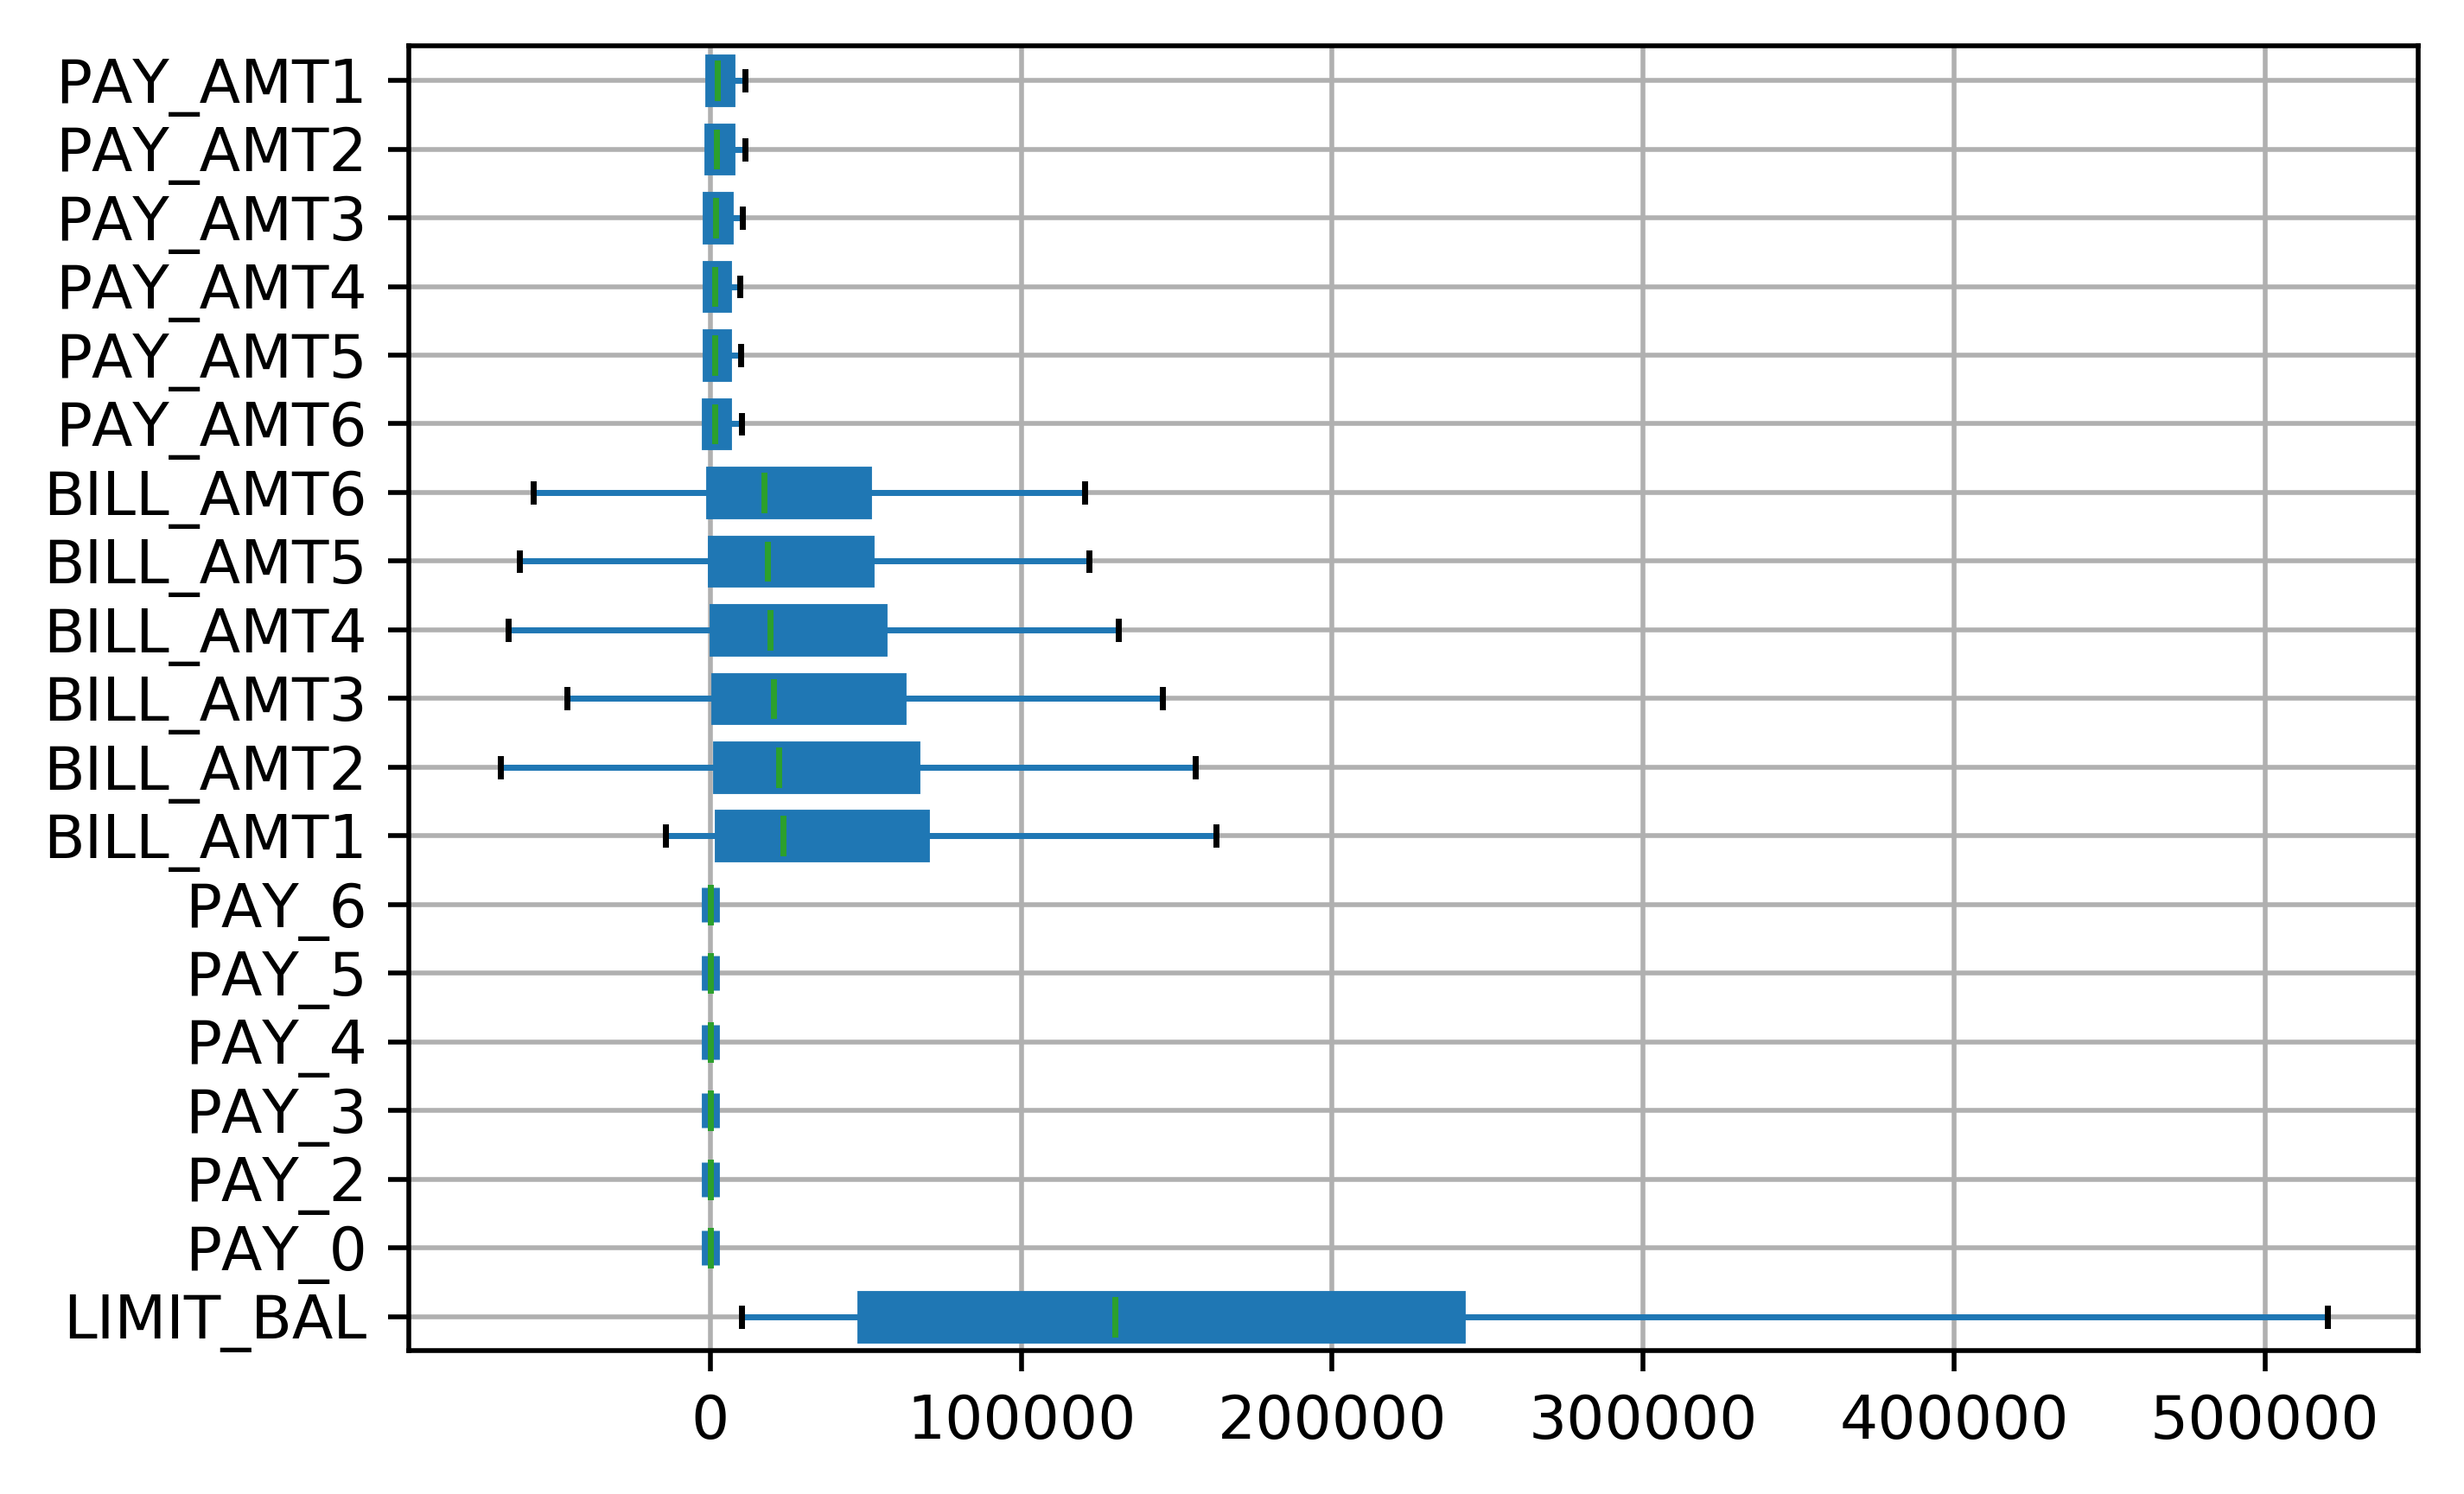

In [46]:
plt.figure(dpi = 500)
df.boxplot(column = ['LIMIT_BAL','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                     'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                     'PAY_AMT6','PAY_AMT5','PAY_AMT4','PAY_AMT3','PAY_AMT2','PAY_AMT1'], 
                    vert = False, patch_artist = True, flierprops=dict(markerfacecolor='g', marker='D'), boxprops = dict(linewidth=3),
                    showfliers = False)

We do see some outliers, but since it is difficult to see from the boxplot what is the exact value for the whisker, we need to use a numerical method, so we use Z-score method (Can also use IQR method)

In [47]:
#Zscore calculation for outlier removal

z = np.abs(stats.zscore(df.iloc[:,4:22].values, axis = 1))
print(type(z))
print(pd.DataFrame(z).isnull().sum().sum()) #z should not have any null values - just a sanity check
print(pd.DataFrame(z).max()) #To see max. z scores in each column
print(pd.DataFrame(z).min()) #To see min. z scores in each column

<class 'numpy.ndarray'>
0
0     4.116907
1     1.341341
2     1.341341
3     1.341341
4     1.341341
5     1.341341
6     1.341341
7     4.123106
8     3.579893
9     3.435900
10    3.652022
11    3.619644
12    4.123059
13    4.122779
14    4.123105
15    4.123078
16    4.123078
17    4.122902
dtype: float64
0     0.002915
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000116
8     0.000092
9     0.000436
10    0.000365
11    0.000769
12    0.000033
13    0.000362
14    0.000298
15    0.000734
16    0.000191
17    0.000053
dtype: float64


In [48]:
#Removing outliers using threshold of zscore = 3

#Setting threshold
threshold = 3
print(np.where(z > 3)) #This return the indexes of Rows and Columns where the threshold was > 3

#Checking how many outliers were found using this threshold
print('Total number of Outliers found using zscore threshold of 3 : ' + str(len(np.where(z > 3)[0]))) #could also have used np.where(z > 3)[1]
print('Total number of Outliers found using zscore threshold of 3.1 : ' + str(len(np.where(z > 3.1)[0])))
print('Total number of Outliers found using zscore threshold of 3.3 : ' + str(len(np.where(z > 3.3)[0]))) 

(array([    0,    14,    18, ..., 14985, 14986, 14992], dtype=int64), array([ 7,  0, 14, ...,  0,  7,  8], dtype=int64))
Total number of Outliers found using zscore threshold of 3 : 1522
Total number of Outliers found using zscore threshold of 3.1 : 1376
Total number of Outliers found using zscore threshold of 3.3 : 1154


## **Since 10% of the data is getting removed as outliers, we decide NOT to remove any Outliers and proceed and see how the model behaves! (Will revisit this!!)

In [15]:
# If we need to remove outliers we can use the below command:
# boston_df_o = boston_df_o[(z < 3).all(axis=1)]

# For now, we will build the model without correcting for dataset imbalance, and try to observe results

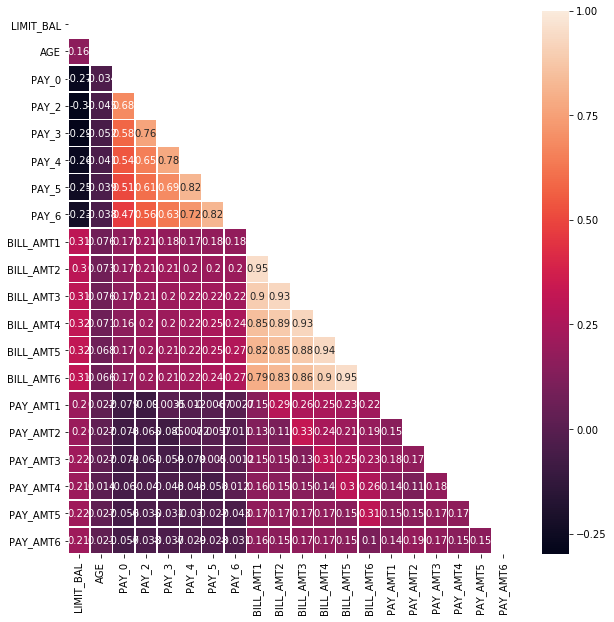

In [85]:
#Observing Correlations between Numeric-Numeric features - Using Pearson's Correlation Coefficient
corr_all_input=df[df.columns].corr()
fig, ax=plt.subplots(figsize=(10,10))
#To plot a lower triangular corr matrix, use the below:
mask = np.zeros_like(corr_all_input)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_all_input, annot=True, linewidths=0.5, ax=ax, mask = mask)
plt.show()

Assuming correlation threshld of ~0.50:
> ## BILL_AMT* are correlated with each other - Makes intuitive sense as a person may spend an equal amount on the credit card every month.

> ## PAY_* are correlaed to each other - Makes intuitive sense.

In [80]:
#Observing Correlations between Categorical-Categorical features - Using Pearson's Chi-squared Null Hypothesis Test
# Condition: For the test to be effective, at least five observations are required in each cell of the contingency table

#Checking correlation between SEX, EDUCATION or MARRIAGE and the output default.payment.next.month- The features with
# low correlation to output can be dropped
X = df.iloc[:,1:4] 
y = df.iloc[:,23]
i = 0
for i in range(0,3):
    f_obs = pd.crosstab(index = X.iloc[:,i], columns = y)
    print('\n' + str(f_obs))
    i = i + 1
    chi2, p, dof, ex = chi2_contingency(observed = f_obs)
    print('chi-squared statistic: ' + str(chisq))
    print('p-value: ' + str(p))
    
#     chisq, p = stats.chisquare(f_obs = f_obs, axis = None) #f_exp are equally likely by default 
#     print('chi-squared statistic: ' + str(chisq))
#     print('p-value: ' + str(p))


default.payment.next.month     0     1
SEX                                   
2                           2479   633
1                           9015  2873
chi-squared statistic: 23089.396266666667
p-value: 7.943996192050907e-06

default.payment.next.month     0     1
EDUCATION                             
2                           5135  1740
1                           4332  1084
3                           1824   665
5                            121     8
4                             48     5
6                             23     4
0                             11     0
chi-squared statistic: 23089.396266666667
p-value: 2.1920283834077937e-18

default.payment.next.month     0     1
MARRIAGE                              
1                           5001  1667
2                           6357  1789
3                            119    48
0                             17     2
chi-squared statistic: 23089.396266666667
p-value: 3.407946869801761e-05


> If p-value <= alpha: significant result, reject null hypothesis (H0), dependent

> If p-value > alpha: not significant result, fail to reject null hypothesis (H0), independent


## Since p-values for all three (SEX, EDUCATION and MARRIAGE) are very small compared to alpha = 0.05, all three are important in predicting the output "Default".

## However, based on p-values, EDUCATION is clearly the most important!!

In [84]:
#Checking correlation between SEX, EDUCATION or MARRIAGE with each other - The features with
# high correlation to the other can be dropped to avoid multicollinearity
X = df.iloc[:,1:4]

#SEX with EDUCATION
f_obs = pd.crosstab(index = X.iloc[:,0], columns = X.iloc[:,1])
print('\n' + str(f_obs))
chi2, p, dof, ex = chi2_contingency(observed = f_obs)
print('chi-squared statistic: ' + str(chisq))
print('p-value: ' + str(p))

#SEX with MARRIAGE
f_obs = pd.crosstab(index = X.iloc[:,0], columns = X.iloc[:,2])
print('\n' + str(f_obs))
chi2, p, dof, ex = chi2_contingency(observed = f_obs)
print('chi-squared statistic: ' + str(chisq))
print('p-value: ' + str(p))

#EDUCATION with MARRIAGE
f_obs = pd.crosstab(index = X.iloc[:,1], columns = X.iloc[:,2])
print('\n' + str(f_obs))
chi2, p, dof, ex = chi2_contingency(observed = f_obs)
print('chi-squared statistic: ' + str(chisq))
print('p-value: ' + str(p))


EDUCATION  0     1     2     3   4   5   6
SEX                                       
2          3  1062  1501   499  11  34   2
1          8  4354  5374  1990  42  95  25
chi-squared statistic: 23089.396266666667
p-value: 0.01599029185305216

MARRIAGE   0     1     2    3
SEX                          
2          5  1478  1593   36
1         14  5190  6553  131
chi-squared statistic: 23089.396266666667
p-value: 0.0013580279908589604

MARRIAGE    0     1     2   3
EDUCATION                    
2           3  3165  3624  83
1           1  2043  3338  34
3          15  1354  1073  47
5           0    66    61   2
4           0    22    30   1
6           0    15    12   0
0           0     3     8   0
chi-squared statistic: 23089.396266666667
p-value: 6.710849111949636e-56


## Here, if we take an alpha = 0.05, all three SEX, EDUCATION and MARRIAGE are correlated to each other (we have to remove 2 variables) => Inferring that "Sex" is not required to predict defaults!!

## But, if we take an alpha = 0.01, SEX and EDUCATION are NOT correlated, only MARRIAGE is correlated with both SEX and EDUCATION (we can remove MARRIAGE) => Inferring that "Sex" is required to predict defaults.

In [ ]:
# Correcting for dataset imbalance
# There are many options available for correcting the class imbalance, however, since we have very less data,
# any oversampling technique would suit best. So, we go with SMOTE for now:


Performance metrics to be used for this problem
1. Confusion Matrix
2. Recall
3. Precision
4. F1 score
5. ROC curve??
6. Kappa? (better than accuracy)

In [ ]:
References:
    1. https://seaborn.pydata.org/generated/seaborn.heatmap.html
    2. http://www.insightsbot.com/blog/2AeuRL/chi-square-feature-selection-in-python
    3. https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
        
        